In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

from tqdm import tqdm

In [2]:
import re
from nltk import tokenize, TweetTokenizer
from pymystem3 import Mystem

In [3]:
from gensim.models import KeyedVectors, FastText

In [4]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.utils import shuffle
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix

In [5]:
DATA_DIR = Path('../data/')
DATASET_DIR = DATA_DIR.joinpath('dataset/')
FASTTEXT_DIR = DATA_DIR.joinpath('fasttext/')

In [6]:
df_random = pd.read_csv(DATASET_DIR.joinpath('rusentiment_random_posts.csv'))
df_preselected = pd.read_csv(DATASET_DIR.joinpath('rusentiment_preselected_posts.csv'))
df_test = pd.read_csv(DATASET_DIR.joinpath('rusentiment_test.csv'))

In [7]:
df_train = pd.concat([df_random, df_preselected], ignore_index=True)

In [8]:
df_train.head()

,label,text
0,negative,"А попа подозревала давно,что ты с кавказа..пер..."
1,speech,З прошедшим Днем Ангела))))))))
2,skip,Два дня до отлёта с острова!!!!!!!
3,negative,"Блин, почему эта жизнь столь не справедлива (((("
4,skip,где еще встречать свой день рождения как не на...


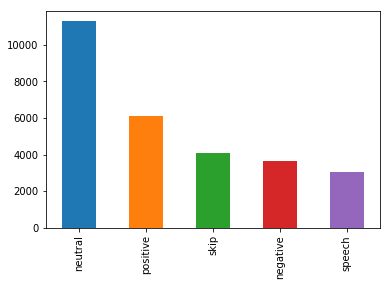

In [10]:
df_train.label.value_counts().plot(kind='bar')

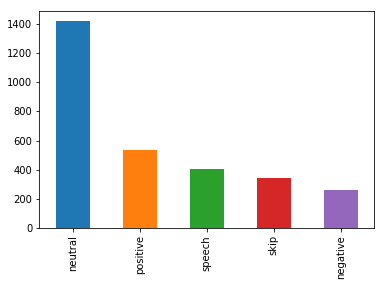

In [11]:
df_test.label.value_counts().plot(kind='bar')

In [15]:
fasttext_file = str(FASTTEXT_DIR.joinpath(
                'araneum_none_fasttextcbow_300_5_2018/araneum_none_fasttextcbow_300_5_2018.model'))
fasttext_file

'../data/fasttext/araneum_none_fasttextcbow_300_5_2018/araneum_none_fasttextcbow_300_5_2018.model'

In [20]:
embeddings = FastText.load(fasttext_file)

In [134]:
class TextPreprocess(object):
    """Препроцессинг текста"""

    def __init__(self):
        self.mystem = Mystem()  # объект морфологического анализатора pymystem3

    def lemmatize(self, text):
        """Получение лемматизированной строки с помощью pymystem3"""
        lem_text = ''.join(self.mystem.lemmatize(text))
        return lem_text

    def tokenize_only(self, text):
        """Токенизация строки с переводом в нижний регистр,
        удалением всего, что не является текстом"""
        # cut all digitst from text
        text = re.sub(r'\d', ' ', text)

        # text tokenization
        tokens = [word.lower() for word in tokenize.WordPunctTokenizer().tokenize(text)]

        # filter out any tokens not containing any letters or digits
        filtered_tokens = [token for token in tokens if re.search(r'\w', token)]

        return filtered_tokens

    def tokenize_with_lemmatize(self, text):
        """Токенизация строки с лемматизацией"""
        return self.tokenize_only(self.lemmatize(text))

In [135]:
textpreprocess = TextPreprocess()

In [65]:
def tokenize_only(text):
    tokenizer = TweetTokenizer()
    text = re.sub(r'#', '# ', text)
    tokens = tokenizer.tokenize(text)
    return tokens

In [103]:
def create_data_matrix_embeddings(samples, embeddings):
    embeddings_dim = embeddings.vector_size
    nb_samples = len(samples)
    X = np.zeros((nb_samples, embeddings_dim), dtype=np.float32)

    nb_empty = 0
    empty_samples = []
    for i, tokens in tqdm(enumerate(samples)):
        tokens_embeddings = []
        for t in tokens:
            try:
                tokens_embeddings.append(embeddings.wv.get_vector(t))
            except KeyError:
                pass

        if len(tokens_embeddings) > 0:
            mean_embeddings = np.mean(tokens_embeddings, axis=0)
            X[i] = mean_embeddings
        else:
            nb_empty += 1
            empty_samples.append(i)

    print(f'Empty samples: {nb_empty}')

    return X, empty_samples

In [91]:
def score_model(model, X, y_true, labels):
    y_pred = model.predict(X)

    if len(set(y_true)) == 2:
        average = 'binary'
        pos_label = int(np.argwhere(labels != 'rest'))
    else:
        average = 'weighted'
        pos_label = 1

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average=average, pos_label=pos_label)
    precision = precision_score(y_true, y_pred, average=average, pos_label=pos_label)
    recall = recall_score(y_true, y_pred, average=average, pos_label=pos_label)

    return accuracy, f1, precision, recall

In [136]:
samples_train = []
for message in tqdm(df_train.text):
    samples_train.append(textpreprocess.tokenize_with_lemmatize(message))
    
labels_train = df_train.label

samples_test = []
for message in tqdm(df_test.text):
    samples_test.append(textpreprocess.tokenize_with_lemmatize(message))
    
labels_test = df_test.label

100%|██████████| 2967/2967 [00:02<00:00, 1025.83it/s]


In [138]:
label_encoder = LabelEncoder()
label_encoder.fit(labels_train)
print(f'Labels: {label_encoder.classes_}')

Labels: ['negative' 'neutral' 'positive' 'skip' 'speech']


In [139]:
y_train = label_encoder.transform(labels_train)
y_test = label_encoder.transform(labels_test)

In [140]:
X_train, empty_samples = create_data_matrix_embeddings(samples_train, embeddings)

28218it [00:05, 4760.06it/s]

Empty samples: 1


In [141]:
X_test, empty_samples_test = create_data_matrix_embeddings(samples_test, embeddings)

2967it [00:00, 4872.11it/s]

Empty samples: 0


In [142]:
for ind in empty_samples:
    print(df_train.text[ind], '-', df_train.label[ind])

Х А Р А Ш О - positive


In [144]:
models = [
    LogisticRegression(),
    LinearSVC(),
    GradientBoostingClassifier(),
    # net,
]
results = []
for model in models:
    model.fit(X_train, y_train)  # , sample_weight=sample_weight

    result = score_model(model, X_train, y_train, label_encoder.classes_)
    results.append(result)

print('===== RESULTS =====')
for model, (accuracy_train, f1_train, precision_train, recall_train) in zip(models, results):
    model_name = model.__class__.__name__
    print(f'{model_name}: F1 train {f1_train:.3f}')

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


===== RESULTS =====
LogisticRegression: F1 train 0.542
LinearSVC: F1 train 0.563
GradientBoostingClassifier: F1 train 0.640


In [145]:
results_test = []
for model in models:

    result = score_model(model, X_test, y_test, label_encoder.classes_)
    results_test.append(result)

print('===== RESULTS TEST =====')
for model, (accuracy_train, f1_train, precision_train, recall_train) in zip(models, results_test):
    model_name = model.__class__.__name__
    print(f'{model_name}: F1 test {f1_train:.3f}')

===== RESULTS TEST =====
LogisticRegression: F1 test 0.627
LinearSVC: F1 test 0.637
GradientBoostingClassifier: F1 test 0.661
